In [496]:
import numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt
import jax
from jax import grad, hessian, jit, vmap
from jax.nn import celu
from functools import partial
from IPython.display import clear_output
import optax
from tqdm import trange



num_particles = 2
num_nodes = 50
m = 1
hbar = 1
omega = 1

g = 0.2
sigma = -g/2.0

class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        
        # Initialize weights and biases for each layer
        self.weights = []
        self.biases = []
        if hidden_sizes != [0]:
            sizes = [input_size] + hidden_sizes + [output_size]
        else:
            sizes = [input_size, output_size]

        for i in range(len(sizes) - 1):
            w = np.random.randn(sizes[i], sizes[i+1]) 
            b = np.random.randn(1, sizes[i+1]) 
            self.weights.append(w)
            self.biases.append(b)

    @partial(jit, static_argnums=(0,))
    def transform(self, coords):
       # if running into NaNs, try to increase this
        C = 2
        ret = jnp.zeros(num_particles)
        for i in range(num_particles):
            ret = ret.at[i].set(jnp.sum(jnp.power(coords/C, i + 1)))
        return ret 

    @partial(jit, static_argnums=(0,))
    def __call__(self, x, params):
        x = self.transform(x)
        self.weights, self.biases = self.unflatten_params(params)
        a = x
        for i in range(len(self.weights) - 1):
            z = jnp.dot(a, self.weights[i]) + self.biases[i]
            a = celu(z)
        a = jnp.dot(a, self.weights[-1]) + self.biases[-1]
        return a[0][0]
    
    @partial(jit, static_argnums=(0,))
    def flatten_params(self):
        params = jnp.array([])
        for i in range(len(self.weights)):
            params = jnp.concatenate((params, self.weights[i].flatten()))
            params = jnp.concatenate((params, self.biases[i].flatten()))
        return jnp.array(params)
    
    @partial(jit, static_argnums=(0,))
    def unflatten_params(self, params):
        weights = []
        biases = []
        start = 0
        for i in range(len(self.weights)):
            end = start + self.weights[i].size
            weights.append(jnp.reshape(jnp.array(params[start:end]), self.weights[i].shape))
            start = end
            end = start + self.biases[i].size
            biases.append(jnp.reshape(jnp.array(params[start:end]), self.biases[i].shape))
            start = end
        return weights, biases
    

# initialize the network
nn = NeuralNetwork(num_particles, [num_nodes], 1)


# symmetrization transformation
# I1 = x_1/C + x_2/C + ... + x_N/C
# I2 = (x_1/C)^2 + (x_2/C)^2 + ... + (x_N/C)^2
# ...
# IN = (x_1/C)^N + (x_2/C)^N + ... + (x_N/C)^N

@jit
def A(coords, params):
    return nn(coords, params) * omega * jnp.sum(coords**2)

@jit
def psi(coords, params):
    return jnp.exp(-A(coords, params)) 

@jit
def sample_testing_fun(coords):
    return jnp.exp(-jnp.sum(coords**2)/2)

@jit
def sample_body(coords_t, params, key, variation_size):    
    gen_rand = jax.random.uniform(key,shape=(num_particles,), minval=-variation_size, maxval=variation_size)
    new_key, subkey = jax.random.split(key)
    coords_prime = coords_t + gen_rand
    temp_rand = jax.random.uniform(subkey, minval=0, maxval=1)
    return (jax.lax.cond(temp_rand <= psi(coords_prime, params)**2/psi(coords_t, params)**2, lambda x, _: x, lambda _, y : y, coords_prime, coords_t), new_key)

def sample(params, num_samples=10**3, thermalization_steps=200, skip_count=50, variation_size=1.0, key=jax.random.PRNGKey(np.random.randint(0,10000)), skipping = True):
    outputs = []

    #coords_t = np.random.uniform(-variation_size, variation_size, num_particles)
    coords_t = np.zeros(num_particles)
    for step in range(num_samples*skip_count + thermalization_steps + 1):
        coords_t, key = sample_body(coords_t, params, key, variation_size)
        if ((step > thermalization_steps) and (step % skip_count == 0)):
            outputs.append(coords_t)
    # create a second output array, where the second coordinate is equal to the first coordinate
    outputs_prime = outputs
    for i in range(len(outputs)):
        a = outputs[i]
        a.at[1].set(a[0])
        outputs_prime[i] = a
    return jnp.array(outputs), jnp.array(outputs_prime)

@jit
def sample_body_test(coords_t, params, key, variation_size):    
    gen_rand = jax.random.uniform(key,shape=(num_particles,), minval=-variation_size, maxval=variation_size)
    new_key, subkey = jax.random.split(key)
    coords_prime = coords_t + gen_rand
    temp_rand = jax.random.uniform(subkey, minval=0, maxval=1)
    return (jax.lax.cond(temp_rand < sample_testing_fun(coords_prime)**2/sample_testing_fun(coords_t)**2, lambda x, _: x, lambda _, y : y, coords_prime, coords_t), new_key)

def sample_test(params, num_samples=10**3, thermalization_steps=200, skip_count=50, variation_size=1.0, key=jax.random.PRNGKey(np.random.randint(0,10000)), skipping = True):
    outputs = []

    #coords_t = np.random.uniform(-variation_size, variation_size, num_particles)
    coords_t = jnp.zeros(2)
    for step in range(num_samples*skip_count + thermalization_steps + 1):
        coords_t, key = sample_body(coords_t, params, key, variation_size)
        if ((step > thermalization_steps) and (step % skip_count == 0)):
            outputs.append(coords_t)
    # create a second output array, where the second coordinate is equal to the first coordinate
    outputs_prime = outputs
    for i in range(len(outputs)):
        a = outputs[i]
        a.at[1].set(a[0])
        outputs_prime[i] = a
    return jnp.array(outputs), jnp.array(outputs_prime)




# sample_body function except it also returns whether or not the move was accepted
@jit
def sample_body_accept(coords_t, params, key, variation_size):
    gen_rand = jax.random.uniform(key, minval=-variation_size, maxval=variation_size)
    new_key, subkey = jax.random.split(key)
    
    coords_prime = coords_t + gen_rand
    r = jax.random.uniform(subkey, minval=0, maxval=1)
    condition = r <= psi(coords_prime, params)**2/psi(coords_t, params)**2
    return (jax.lax.cond(condition, lambda x, _: x, lambda _, y : y, coords_prime, coords_t), new_key, condition)


# the sample function without any thermalization steps or skipping steps
def accept_ratio(params, num_samples=10**3, variation_size=5.0, key=jax.random.PRNGKey(np.random.randint(0,100))):
    coords_t = np.random.uniform(-variation_size, variation_size)
    num_accepted = 0
    for _ in range(num_samples):
        coords_t, key, accepted = sample_body_accept(coords_t, params, key, variation_size)
        if accepted:
            num_accepted += 1

    return num_accepted / num_samples



psi_hessian = hessian(psi)

@jit
def ddpsi(coords, params):
    return jnp.diagonal(psi_hessian(coords, params))

# first derivative of the neural network with respect to the coordinates
# in Andy's notation this is dA/dx
dA_dx = jit(grad(A, 0, allow_int=True)) # type: ignore

# second derivative of the neural network with respect to the coordinates
# in Andy's notation this is d^2A/dx^2


A_hessian = jax.jacfwd(grad(A), 0) # type: ignore


@jit
def d2A_dx2(coords, params):
    #return jnp.diagonal(A_hessian(transform(coords), params))
    return jnp.diagonal(A_hessian(coords, params))


@jit
def Hpsi(coords, params, samples):
    return Hpsi_without_delta(coords, params) + delta_potential(coords, params, samples)

@jit
def Hpsi_without_delta(coords, params):
   # sigma term
    N = len(coords)
    sigma_term = 0
    for i in range(N):
        for j in range(i,N):
            sigma_term += sigma * jnp.abs(coords[i] - coords[j])
    return jnp.sum((m*.5*omega**2*coords**2)) - hbar**2 / (2*m) * jnp.sum(ddpsi(coords, params) ) * 1/psi(coords, params) + sigma_term 
    #return 1/(2*m) * (jnp.sum(d2A_dx2(coords, params)) - jnp.sum(jnp.square(dA_dx(coords, params)))) + jnp.sum((m*.5*omega**2*coords**2)) + sigma_term

@jit
def delta_potential(coords, params, samples):
    N = len(coords)
    # make a copy of the parameters and set the second one to be equal to the first one
    coords_prime = coords.at[1].set(coords[0])
    # compute e^(-2 NN(params_prime))
    ratio = jnp.exp(-2 * A(coords_prime, params) + 2 * A(coords, params))
    # get a list of the second coordinates
    y_max = jnp.max(jnp.abs(jnp.array(samples[:,1])))
    # compute alpha
    alpha = y_max/(jnp.sqrt(-jnp.log(jnp.sqrt(jnp.pi) * 10**(-5))))
    delta_dist = 1/(jnp.sqrt(2*jnp.pi) * alpha) * jnp.exp(-coords[1]**2/(alpha**2))
    return g * N*(N-1)/2 * ratio * delta_dist

vdelta_potential = jit(vmap(delta_potential, in_axes=(0, None, None), out_axes=0))
venergy = jit(vmap(Hpsi, in_axes=(0, None, None), out_axes=0))
vHpsi_without_delta = jit(vmap(Hpsi_without_delta, in_axes=(0, None), out_axes=0))


# derivative of the neural network with respect to every parameter
# in Andy's notation this is dA/dtheta
dnn_dtheta = jit(grad(A, 1)) # type: ignore
vdnn_dtheta = vmap(dnn_dtheta, in_axes=(0, None), out_axes=0)

vboth = vmap(jnp.multiply, in_axes=(0, 0), out_axes=0)

def gradient(params, num_samples=10**3, thermal=200, skip=50, variation_size=1.0, verbose=False):
    # get the samples
    samples, samples_prime = sample(params, num_samples, thermal, skip, variation_size)

    psiHpsi = venergy(samples, params, samples)
    Hpsi_terms_without_delta = vHpsi_without_delta(samples, params)
    delta_term = vdelta_potential(samples, params, samples)

    # delta function additions
    dA_dtheta = vdnn_dtheta(samples, params)
    dA_dtheta_repeated = vdnn_dtheta(samples_prime, params)

    dA_dtheta_avg = 1/num_samples * jnp.sum(dA_dtheta, 0)

    second_term = 1/num_samples * jnp.sum(vboth(dA_dtheta, Hpsi_terms_without_delta), 0) 

    third_term =1/num_samples * jnp.sum(vboth(dA_dtheta_repeated,delta_term), 0)
    uncert = jnp.std(psiHpsi)/jnp.sqrt(num_samples)

    energy = 1/num_samples * jnp.sum(psiHpsi, 0)
    if verbose:
        print(energy)

    N = len(samples[0])
    gradient_calc = 2 * energy * dA_dtheta_avg - 2 * second_term - g * N*(N-1) * third_term
    return gradient_calc, energy, uncert

# define a function that takes in samples, bins them, and returns the average of each bin
def bin_samples(energies, bin_size):
    # first, bin the samples
    binned = np.array_split(energies, bin_size)
    # now, calculate the average of each bin
    binned_averages = [np.mean(b) for b in binned]
    # now, calculate the uncertainty of each bin
    bin_uncerts = np.std(binned_averages)/np.sqrt(bin_size)
    return bin_uncerts


# define a function that gets all samples, and then bins them with different bin sizes
def autocorrelation(params):
    samples = sample(params, num_samples=10**3, thermalization_steps=200, skip_count=40, variation_size=1, key=jax.random.PRNGKey(np.random.randint(0,100)), skipping = False)[0]
    energies = [Hpsi(s, params) for s in samples]
    
    bins = np.linspace(1, 100, 100, dtype=int)
    # now plot the average energy as a function of the number of bins
    us = []
    for b_size in bins:
        us.append(bin_samples(energies, b_size))
    plt.scatter(bins, us)
    plt.title("Bin size vs. Uncertainty")
    plt.xlabel("Bin size")
    plt.ylabel("Uncertainty")
    plt.show()

def train(params, iterations, N, thermal, skip, variation_size, optimizer):
    hs = []
    us = []
    opt_state = optimizer.init(params)
    
    def step(params, opt_state, N, thermal, skip, variation_size):
        gr = gradient(params, N, thermal, skip, variation_size)
        # print(gr)
        hs.append(gr[1])
        us.append(gr[2])
        updates, opt_state = optimizer.update(gr[0], opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, gr[1]

    pbar = trange(iterations, desc="", leave=True)
    for step_num in pbar:   
        params, opt_state, energy = step(params, opt_state, N, thermal, skip, variation_size)
        pbar.set_description("Energy = " + str(energy), refresh=True)
        if np.isnan(energy):
            print("NaN encountered, stopping...")
            break
    clear_output(wait=True)
    return hs, us, params

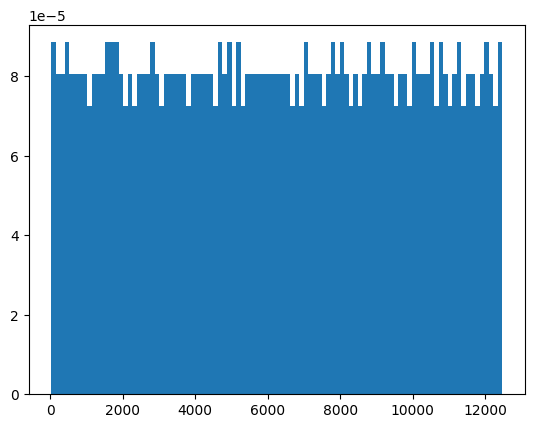

In [497]:
x_plt = np.linspace(-5, 5, 1000)
y_plt = [np.sqrt(2 * np.pi) * jnp.exp(-x**2/2) for x in x_plt]

samples = sample_test(nn.flatten_params(), num_samples=10**3, thermalization_steps=200, skip_count=50, variation_size=1.0, key=jax.random.PRNGKey(np.random.randint(0,100)), skipping = True)[0]
xs = samples[:,0]
plt.hist(xs, bins=100, density=True)
#plt.scatter(x_plt, y_plt, color='red')
plt.show()

In [447]:
variation = .3
print("Accept/Reject ratio", accept_ratio(nn.flatten_params(), num_samples=10**3, variation_size=variation))

Accept/Reject ratio 0.471


In [456]:
samples1 = sample(nn.flatten_params(), num_samples=15, thermalization_steps=200, skip_count=40, variation_size=variation, key=jax.random.PRNGKey(np.random.randint(0,100)), skipping = True)[0]
samples2 = sample(nn.flatten_params(), num_samples=15, thermalization_steps=200, skip_count=40, variation_size=variation, key=jax.random.PRNGKey(np.random.randint(0,100)), skipping = True)[0]
print(samples1)
print(samples2)

[[-2.3679264 -2.3546484]
 [-2.2651439 -2.4769118]
 [-2.497939  -2.0736437]
 [-2.4625738 -2.2027557]
 [-2.3034987 -2.324111 ]
 [-2.4679713 -2.245092 ]
 [-2.1281438 -2.3500109]
 [-2.3441296 -2.2700653]
 [-2.323872  -2.2869565]
 [-2.3208191 -2.2965863]
 [-2.2629442 -2.3043716]
 [-2.19731   -2.4074404]
 [-2.292863  -2.3821988]
 [-2.4768326 -2.252401 ]
 [-2.0498903 -2.5434833]]
[[-2.3368657 -2.3848772]
 [-2.4142904 -2.2713778]
 [-2.3334708 -2.2249887]
 [-2.3867784 -2.2188222]
 [-2.4386048 -2.2798753]
 [-2.346987  -2.2634313]
 [-2.5190642 -2.2631383]
 [-2.2762837 -2.2588573]
 [-2.434171  -2.1342673]
 [-2.393994  -2.197906 ]
 [-2.4464128 -2.3542793]
 [-2.4867625 -2.1262589]
 [-2.3574398 -2.3758016]
 [-2.4623098 -2.29373  ]
 [-2.145736  -2.4094045]]


In [498]:
total_hists = []
total_uncerts = []
start_params = nn.flatten_params()

hists, uncerts, params = train(start_params, 50, 10**3, 200, 40, variation, optax.adam(0.01))
total_hists = total_hists + list(hists)
total_uncerts = total_uncerts + list(uncerts) 

Energy = nan:   0%|          | 0/50 [00:02<?, ?it/s]

NaN encountered, stopping...


In [272]:
hists_b, uncerts_b, params_b = train(params, 50, 10**3, 200, 40, variation, optax.adam(0.01))
total_hists = total_hists + list(hists_b)
total_uncerts = total_uncerts + list(uncerts_b) 

Energy = -15.492145: 100%|██████████| 50/50 [01:00<00:00,  1.20s/it] 


In [273]:
hists_c, uncerts_c, params_c = train(params_b, 50, 10**3, 200, 40, variation, optax.adam(0.01))
total_hists = total_hists + list(hists_c)
total_uncerts = total_uncerts + list(uncerts_c) 

Energy = nan:   2%|▏         | 1/50 [00:02<02:03,  2.52s/it]       

NaN encountered, stopping...


In [ ]:
hists_d, uncerts_d, params_d = train(params_c, 50, 10**3, 200, 40, variation, optax.adam(0.01))
total_hists = total_hists + list(hists_d)
total_uncerts = total_uncerts + list(uncerts_d) 

In [ ]:
hists_e, uncerts_e, params_e = train(params_d, 50, 10**3, 200, 40, variation, optax.adam(0.01))
total_hists = total_hists + list(hists_e)
total_uncerts = total_uncerts + list(uncerts_e) 

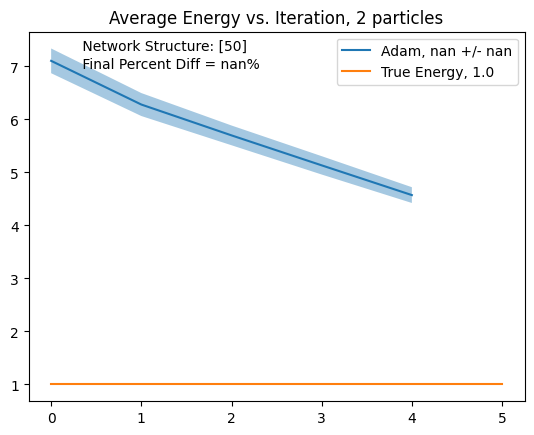

In [341]:
true_energy = .5 * hbar * omega * num_particles
plt.plot(np.arange(0, len(total_hists)), total_hists, label="Adam, " + str(round(total_hists[-1],3)) + " +/- " + str(round(total_uncerts[-1], 2)))
# plot the uncertainties
a_hists = np.array(total_hists)
a_uncerts = np.array(total_uncerts)
plt.fill_between(np.arange(0,len(total_hists)), a_hists - a_uncerts, a_hists + a_uncerts, alpha=.4)
# get the network structure
structure = nn.hidden_sizes
plt.annotate(" Network Structure: " + str(structure), xy=(0.1, 0.95), xycoords='axes fraction')
plt.plot(np.arange(0, len(total_hists)), [true_energy for x in np.arange(0, len(total_hists))], label=r"True Energy, " + str(round(true_energy,3)))
pdiff = (total_hists[-1] - true_energy)/true_energy*100
plt.annotate(" Final Percent Diff = " + str(round(pdiff,3)) + "%", xy=(.1, .9), xycoords= 'axes fraction')
plt.legend()
plt.title("Average Energy vs. Iteration, " + str(num_particles) + " particles")
plt.show()